<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">IFT 6135 - Homework 3</div>

# Loading local files

In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()

Saving classify_svhn.py to classify_svhn (1).py
Saving density_estimation.py to density_estimation (1).py
Saving samplers.py to samplers (1).py
Saving score_fid.py to score_fid (1).py


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
import samplers
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

# Problem 1 :

## Question 1.1:

In order to estimate the Jensen Shannon Divergence, we will train a parametrized discriminator $D_\theta$ trained to maximize the objective function (1). After training, provided that our discriminator is of sufficient capacity, the objective function will approximate the JSD between $p$ and $q$.

* **First**, we implement the objective function
* **Second**, we create a discriminator $D_\theta$ in the form of an MLP with 3 hidden layers. As we deduce from (1) that $\forall x, D_\theta(x) \in ]0,1[$, the output non-linearity is a sigmoid
* **Third**, we implement a function that, provided 2 samplers of the distributions $p,q$, compute the JSD by training the discriminator (for 30 000 steps) and returning the last objective value computed.

The objective function that our neural network should optimize in the case we are using the Jensen Shannon Divergence is: 

<h4 align="center"> $obj =  \log 2 + \dfrac{1}{2} \mathbb{E}_{x \sim p} [ \log D_\theta (x) ] + \dfrac{1}{2} \mathbb{E}_{y \sim q} [ \log(1 - D_\theta(y))] \quad  \quad (1)$ </h4>

In the case we are using batches of size $m$, this expression is approximated by:

<h4 align="center"> $obj \simeq  \log 2 + \dfrac{1}{2 m} \sum_{i=1}^m  \log D_\theta (x_i)  + \dfrac{1}{2m} \sum_{i=1}^m \log(1 - D_\theta(y_i))$ </h4>

In [0]:
class objective_function_JSD(nn.Module):
    
    def __init__(self):
        super(objective_function_JSD, self).__init__()
    
    def forward(self, D_p, D_q):
        
        objective = torch.log(torch.tensor([2.])).cuda() + 0.5*torch.mean(torch.log(D_p)).cuda() + 0.5*torch.mean(torch.log(1 - D_q)).cuda()
        
        return(objective)

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, input_dim, n_hidden):
        super(Discriminator, self).__init__()
        
        self.hidden1 = nn.Linear(input_dim, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.hidden3 = nn.Linear(n_hidden, n_hidden)
        self.out   = nn.Linear(n_hidden, 1)

    def forward(self, x):
        
        D = F.relu(self.hidden1(x))
        D = F.relu(self.hidden2(D))
        D = F.relu(self.hidden3(D))
        D = torch.sigmoid(self.out(D))
        
        return(D)

In [0]:
def approx_JSD(iter_sampler_p, iter_sampler_q, print_evolution = True):
    
    samples_p = torch.FloatTensor(next(iter_sampler_p)).cuda()
    samples_q = torch.FloatTensor(next(iter_sampler_q)).cuda()
    
    n_hidden = 32
    input_dim = samples_q.shape[1]
    MLP = Discriminator(input_dim, n_hidden).cuda()
    obj_func = objective_function_JSD().cuda()
    optimizer = optim.SGD(MLP.parameters(), lr=1e-3)
    
    for epoch in range(30000):
        
        optimizer.zero_grad()
        d_p = MLP(samples_p)
        d_q = MLP(samples_q)
        loss = -obj_func(d_p, d_q)
        loss.backward()
        optimizer.step()
        
        samples_p = torch.FloatTensor(next(iter_sampler_p)).cuda()
        samples_q = torch.FloatTensor(next(iter_sampler_q)).cuda()
        
        obj = float(obj_func(d_p, d_q))
        
        if epoch % 1000 == 0 and print_evolution:
            print('Epoch : %d Objective : %.4f' % (epoch, obj))
    
    return(obj)

## Question 1.2

We procede in the same way than **Q.1.1**, except that now the objective to maximize is:

<h4 align="center"> $\mathbf{E}_{x\sim p}[T_\theta(x)]-\mathbf{E}_{y\sim q}[T_\theta(y)] - \lambda \mathbf{E}_{z\sim r} [(||\nabla_z T_\theta(z)||_2 - 1)^2]$ </h4>
 
 with $r$ the distribution over $z=ax+(1-a)y$, where $x\sim p$, $y\sim q$ and $a\sim U[0,1]$. We also have $\lambda \geq 10$.

* We fix $\lambda = 10$
* We change the output activation function compared to before *(here we finish with a linear one)*

In [0]:
class objective_function_WD(nn.Module):
    
    def __init__(self):
        super(objective_function_WD, self).__init__()
    
    def forward(self, T_p, T_q, grad_T_r, lmbd):
        
        objective = torch.mean(T_p - T_q - lmbd*(torch.norm(grad_T_r, dim=1) - 1)**2).cuda()
        
        return(objective)

In [0]:
class Critic(nn.Module):
    
    def __init__(self, input_dim, n_hidden):
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(input_dim, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.hidden3 = nn.Linear(n_hidden, n_hidden)
        self.out   = nn.Linear(n_hidden, 1)

    def forward(self, x):
        
        T = F.relu(self.hidden1(x))
        T = F.relu(self.hidden2(T))
        T = F.relu(self.hidden3(T))
        T = self.out(T)
        
        return(T)

In [0]:
def approx_WD(iter_sampler_p, iter_sampler_q, print_evolution=True):
    
    samples_a = torch.FloatTensor(np.random.uniform(0, 1, (512, 1))).cuda()
    samples_p = torch.FloatTensor(next(iter_sampler_p)).requires_grad_().cuda()
    samples_q = torch.FloatTensor(next(iter_sampler_q)).requires_grad_().cuda()
    samples_r = samples_a*samples_p + (1-samples_a)*samples_q
    
    n_hidden = 32
    input_dim = samples_q.shape[1]
    MLP = Critic(input_dim, n_hidden).cuda()
    obj_func = objective_function_WD().cuda()
    optimizer = optim.SGD(MLP.parameters(), lr=1e-3)
    
    for epoch in range(30000):
        
        optimizer.zero_grad()
        t_p = MLP(samples_p)
        t_q = MLP(samples_q)
        t_r = MLP(samples_r)
        grad_t_r = torch.autograd.grad(t_r, samples_r, grad_outputs=torch.ones(512, input_dim).cuda(), create_graph=True)[0].cuda()
        loss = -obj_func(t_p, t_q, grad_t_r, 10)
        loss.backward()
        optimizer.step()
        
        samples_a = torch.FloatTensor(np.random.uniform(0, 1, (512, 1))).cuda()
        samples_p = torch.FloatTensor(next(iter_sampler_p)).requires_grad_().cuda()
        samples_q = torch.FloatTensor(next(iter_sampler_q)).requires_grad_().cuda()
        samples_r = samples_a*samples_p + (1-samples_a)*samples_q

        obj = float(obj_func(t_p, t_q, grad_t_r, 11))
        
        if epoch % 1000 == 0 and print_evolution:
            print('Epoch : %d Objective : %.4f' % (epoch, obj))
        
        # The wasserstein distance is computed without the gradient penalty
        # We put lambda to 0 for that
        wasserstein_dist = float(obj_func(t_p, t_q, grad_t_r, 0))
    
    return(wasserstein_dist)

## Question 1.3

We use the two functions $\texttt{approx_JSD}$ and $\texttt{approx_WD}$ to plot the two graphs for different values of $\phi$.

In [0]:
def plot_graphs():
    
    WDs = []
    JSDs = []
    iter_sampler_p = iter(samplers.distribution1(0))
    phis = np.linspace(-1,1,21)
    begin, cpt = time.time(), 0
    
    for phi in phis:
        
        iter_sampler_q = iter(samplers.distribution1(phi))
        WDs.append(approx_WD(iter_sampler_p, iter_sampler_q, print_evolution=False))
        JSDs.append(approx_JSD(iter_sampler_p, iter_sampler_q, print_evolution=False))
        
        end = time.time()
        print('Epoch : %d /21 Time taken so far: %.4f' % (cpt, end-begin))
        cpt+=1
        
    plt.figure(1,figsize=(8,8))
    plt.subplot(211)
    plt.plot(phis, JSDs)
    plt.title('Approximation of the JSD for different values of $\phi$')
    plt.subplot(212)
    plt.plot(phis, WDs)
    plt.title('Approximation of the WD for different values of $\phi$')
    plt.show()

Epoch : 0 /21 Time taken so far: 234.7283
Epoch : 1 /21 Time taken so far: 467.8309
Epoch : 2 /21 Time taken so far: 696.8242
Epoch : 3 /21 Time taken so far: 926.8644
Epoch : 4 /21 Time taken so far: 1187.7007
Epoch : 5 /21 Time taken so far: 1618.4888
Epoch : 6 /21 Time taken so far: 1856.3620
Epoch : 7 /21 Time taken so far: 2086.1602
Epoch : 8 /21 Time taken so far: 2315.7649
Epoch : 9 /21 Time taken so far: 2544.5423
Epoch : 10 /21 Time taken so far: 2773.8178
Epoch : 11 /21 Time taken so far: 3001.5114
Epoch : 12 /21 Time taken so far: 3260.0702
Epoch : 13 /21 Time taken so far: 3523.1438
Epoch : 14 /21 Time taken so far: 3762.1069
Epoch : 15 /21 Time taken so far: 4077.0614
Epoch : 16 /21 Time taken so far: 4357.6357
Epoch : 17 /21 Time taken so far: 4586.6063
Epoch : 18 /21 Time taken so far: 4815.6555
Epoch : 19 /21 Time taken so far: 5045.0977
Epoch : 20 /21 Time taken so far: 5272.9719


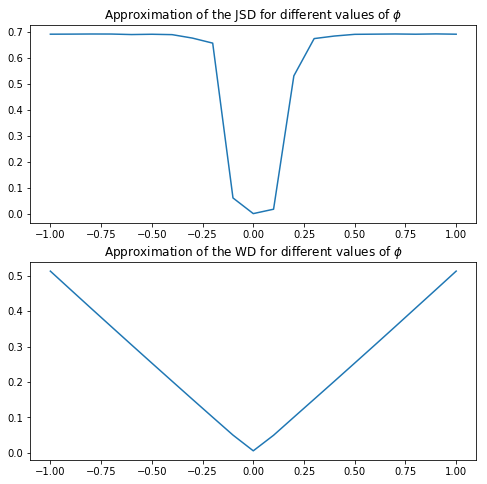

In [0]:
plot_graphs()

After running it on a google colab, we obtain:
![title](Q1_3.png)

## Question 1.4

This time, our discriminator has the following objective function:

<h4 align="center"> $obj =   \mathbb{E}_{x \sim f_1} [ \log D_\theta (x) ] + \mathbb{E}_{y \sim f_0} [ \log(1 - D_\theta(y))]$ </h4>

We use the same discriminator as in **Q.1.1**

In [0]:
class objective_function_JSD(nn.Module):
    
    def __init__(self):
        super(objective_function_JSD, self).__init__()
    
    def forward(self, D_f1, D_f0):
        
        objective = torch.mean(torch.log(D_f1)).cuda() + torch.mean(torch.log(1 - D_f0)).cuda()
        
        return(objective)

In [0]:
def train_discriminator(iter_sampler_f1, iter_sampler_f0, print_evolution = True):
    
    samples_p = torch.FloatTensor(next(iter_sampler_f1)).cuda()
    samples_q = torch.FloatTensor(next(iter_sampler_f0)).cuda()
    
    n_hidden = 32
    input_dim = samples_q.shape[1]
    MLP = Discriminator(input_dim, n_hidden).cuda()
    obj_func = objective_function_JSD().cuda()
    optimizer = optim.SGD(MLP.parameters(), lr=1e-3)
    
    for epoch in range(30000):
        
        optimizer.zero_grad()
        d_p = MLP(samples_p)
        d_q = MLP(samples_q)
        loss = -obj_func(d_p, d_q)
        loss.backward()
        optimizer.step()
        
        samples_p = torch.FloatTensor(next(iter_sampler_f1)).cuda()
        samples_q = torch.FloatTensor(next(iter_sampler_f0)).cuda()
        
        obj = float(obj_func(d_p, d_q))
        
        if epoch % 1000 == 0 and print_evolution:
            print('Epoch : %d Objective : %.4f' % (epoch, obj))
    
    return(MLP)

Text(0.5, 1.0, 'Estimated vs True')

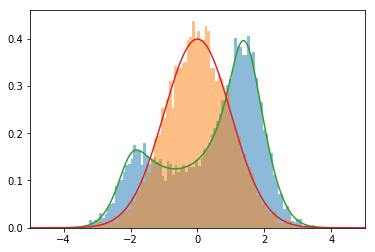

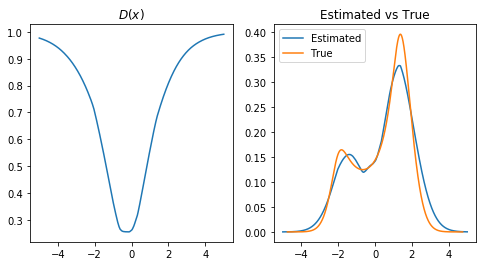

In [0]:
# The following is taken from density_estimation.py


from __future__ import print_function
import numpy as np
import torch 
import matplotlib.pyplot as plt

# plot p0 and p1
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))


############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4

#######--- INSERT YOUR CODE BELOW ---#######
 
discriminator = train_discriminator(iter(samplers.distribution4(512)), iter(samplers.distribution3()), False)
D = lambda x: discriminator(torch.FloatTensor(x).reshape(len(x),1).cuda()).cpu().detach().numpy()[:,0]
# apply the formula f1(x) = f0(x)*D(x)/(1-D(x))
estimator = lambda x: N(x)*D(x)/(1 - D(x))

############### plotting things
############### (1) plot the output of your trained discriminator 
############### (2) plot the estimated density contrasted with the true density



r = D(xx) # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')

estimate = estimator(xx) # estimate the density of distribution4 (on xx) using the discriminator; 
                                # replace "np.ones_like(xx)*0." with your estimate
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')

# Question 2

## 2.1 Train a VAE

In [0]:
import numpy as np

from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam
from torch.autograd import Variable

In [0]:
batch_size=64

def get_data_loader(dataset_location, batch_size):
    def lines_to_np_array(lines): return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        with open(filepath) as f: lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

train, valid, test = get_data_loader("binMNIST/", batch_size)

torch.Size([64, 1, 28, 28])


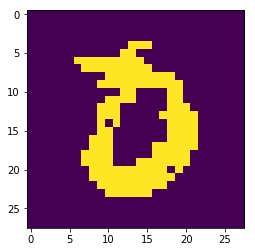

In [0]:
import matplotlib.pyplot as plt
for x in train: 
  print(x.shape)
  plt.imshow(x[0, 0])
  break

### Implementing VAE

In [0]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3)),
            nn.ELU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 64, (3, 3)),
            nn.ELU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(64, 256, (5, 5)),
            nn.ELU()
        )
        self.lin = nn.Linear(256, 200)  # Mean and log variance

    def forward(self, x):

        h = self.conv(x)
        h = self.lin(h.view(-1, 256))

        return h


class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()

        self.conv = nn.Sequential(
            nn.ELU(),

            nn.Conv2d(256, 64, (5, 5), padding=(4, 4)),
            nn.ELU(),
            nn.UpsamplingBilinear2d(scale_factor=2),

            nn.Conv2d(64, 32, (3, 3), padding=(2, 2)),
            nn.ELU(),
            nn.UpsamplingBilinear2d(scale_factor=2),

            nn.Conv2d(32, 16, (3, 3), padding=(2, 2)),
            nn.ELU(),
            nn.Conv2d(16, 1, (3, 3), padding=(2, 2))
        )

        self.conv1 = nn.Conv2d(256, 64, (5, 5), padding=(4, 4))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), padding=(2, 2))
        self.conv3 = nn.Conv2d(32, 16, (3, 3), padding=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, (3, 3), padding=(2, 2))
        self.lin = nn.Linear(100, 256)
        self.up1 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up2 = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x):

        h = self.lin(x)
        h = self.conv(h.view(-1, 256, 1, 1))

        return h


def sample_2(encoded_layer):
    mean, log_var = encoded_layer.chunk(2, 1)
    eps = torch.normal(mean=torch.zeros_like(mean), std=1).cuda()
    return mean + torch.exp(log_var/2)*eps


class VAE2(nn.Module):
    def __init__(self):
        super(VAE2, self).__init__()

        self.encoder = Encoder2()
        self.decoder = Decoder2()

    def forward(self, x):

        h = self.encoder(x)
        z = sample_2(h)
        return self.decoder(z), h

In [0]:
model = VAE2().cuda()

model(x[0:20].cuda())[0].size()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


torch.Size([20, 1, 28, 28])

### Training the model

In [0]:
def ELBO_loss_fun(pred, truth, encoded_layer):
    mean, log_var = encoded_layer.chunk(2, 1)
    recon_loss = F.binary_cross_entropy_with_logits(pred, truth, reduction='sum')
    kl = 0.5 * torch.sum(torch.exp(log_var) + mean.pow(2) - 1. - log_var)
    return recon_loss + kl

In [0]:
def evaluate(model, which=valid, verbose=0):
  loss = 0
  N = 0
  for data in which:
      data = data.cuda()
      N += data.size()[0]
      output, encoded_layer = model(data)
      batch_loss = ELBO_loss_fun(output, data, encoded_layer)
      loss += batch_loss.cpu().detach().numpy()
      if verbose:
        print(loss)
  return -loss/N

In [0]:
evaluate(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


-544.7511301757812

In [0]:
num_epochs = 20
learning_rate = 3e-4

optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for data in train:
        
        data = Variable(data).cuda()
        # ===================forward=====================
        output, encoded_layer = model(data)
        loss = ELBO_loss_fun(output, data, encoded_layer)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    # ===================loss========================
    val_loss = evaluate(model)
    print('epoch [{}/{}], batch loss:{:.4f}, val loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss) )

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch [1/20], batch loss:2331.3994, val loss:-135.4004
epoch [2/20], batch loss:1874.8628, val loss:-116.1813
epoch [3/20], batch loss:1781.6560, val loss:-109.2262
epoch [4/20], batch loss:1597.2383, val loss:-106.2564
epoch [5/20], batch loss:1572.1377, val loss:-103.5949
epoch [6/20], batch loss:1672.1812, val loss:-102.3747
epoch [7/20], batch loss:1623.7435, val loss:-100.0657
epoch [8/20], batch loss:1401.1921, val loss:-100.0128
epoch [9/20], batch loss:1541.8154, val loss:-98.4329
epoch [10/20], batch loss:1812.1547, val loss:-98.0201
epoch [11/20], batch loss:1588.2959, val loss:-97.6232
epoch [12/20], batch loss:1559.8503, val loss:-97.0715
epoch [13/20], batch loss:1556.3387, val loss:-96.5338
epoch [14/20], batch loss:1549.3711, val loss:-96.3763
epoch [15/20], batch loss:1384.4280, val loss:-95.9730
epoch [16/20], batch loss:1578.9799, val loss:-96.0371
epoch [17/20], batch loss:1542.2117, val loss:-95.0684
epoch [18/20], batch loss:1572.5564, val loss:-95.3175
epoch [19/2

In [0]:
evaluate(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


-94.32451394042968

In [0]:
evaluate(model, test)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


-93.52025546875

## 2.2 Evaluating with log likelihood

In [0]:
from scipy.stats import norm
from scipy.special import expit

In [0]:
def compute_pz(z):
    return norm.pdf(z)

In [0]:
def compute_qz(model, x, z):
    data = torch.Tensor(x).view(-1, 1, 28, 28)
    encoded_layer = model.encoder(data.cuda()).detatch()
    mean, log_var = encoded_layer.chunk(2, 1)
    qz = [norm.pdf(z[i], loc=mean[i], scale=np.exp(log_var[i])) for i in range(len(m))]
    return np.array(qz)

In [0]:
def estimate_log_px(model, x, z):
    m, d = x.shape
    _, k, l = z.shape 
  
    # First, let's compute p(z):
    pz = norm.pdf(z)  # for each unit
    log_pz = np.sum(np.log(pz), axis=-1)  # Using log-sum trick to get the product
    
    # Then, let's compute q(z|x) for each unit:
    data = torch.Tensor(x).view(-1, 1, 28, 28)
    encoded_layer = model.encoder(data.cuda())
    mean, log_var = encoded_layer.chunk(2, 1)
    mean, log_var = mean.cpu(), log_var.cpu()
    qz = [norm.pdf(z[i], loc=mean[i], scale=np.exp(log_var[i]/2)) 
          for i in range(len(mean))]
    qz = np.array(qz)  # for each unit
    log_qz = np.sum(np.log(qz), axis=-1)
    
    # Then, let's compute p(x|z) for each unit (it's cross entropy):
    samples = torch.Tensor(z).view(-1, 100)
    predict = model.decoder(samples.cuda())
    predict = predict.view(-1, k, d)  # mxkxd
    predict = predict.transpose(0,1)  # kxmxd
    predict = predict.cpu().numpy()
    log_pxz = []
    for pred in predict:
        log_sample = np.sum(x * np.log(expit(pred)) + (1. - x) * np.log(1.0 - expit(pred)), axis=-1)
        log_pxz.append(log_sample)
    log_pxz = np.array(log_pxz)  #kxm
    log_pxz = np.swapaxes(log_pxz, 0, 1)  #mxk
    
    log_px = log_pxz + log_pz - log_qz  # as we're still using log-sum trick
    log_px = np.log(np.mean(np.exp(log_px), axis=1))  # Computing log_px
    
    return log_px

In [0]:
def generate_samples(encoded_layer, k):
    mean, log_var = encoded_layer.chunk(2, 1)
    z = []
    for mu, log_v in zip(mean.cpu().numpy(), log_var.cpu().numpy()):
        z.append([np.random.normal(mu[i], np.exp(log_v[i]/2), k)
                  for i in range(len(mu))])
    z = np.array(z)
    return np.swapaxes(z, 1, 2)

In [0]:
def evaluate_log_px(model, which=valid, verbose=1):
    objectif = 0
    N = 0
    batch = 0
    for data in which:
        batch+=1
        if verbose and batch%10==0:
            print("batch:",batch,"status:",objectif/N)
        with torch.no_grad():
            # Forward
            data = data.cuda()
            output, encoded_layer = model(data)

            # Generating x and z as ne
            x = data.view(-1, 784).cpu().numpy()
            m = x.shape[0]
            N += m
            z = generate_samples(encoded_layer, 200)
            batch_objectif = estimate_log_px(model, x, z)
            objectif += np.sum(batch_objectif)
    return objectif/N

In [0]:
evaluate_log_px(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


batch: 10 status: -88.87073899017825
batch: 20 status: -88.99005074717807
batch: 30 status: -88.4494725958603
batch: 40 status: -88.64026675468861
batch: 50 status: -88.61309733374397
batch: 60 status: -88.70590530900337
batch: 70 status: -88.5993502249774
batch: 80 status: -88.69649875157636
batch: 90 status: -88.9265610715069
batch: 100 status: -88.8397076475613
batch: 110 status: -88.85134359879261
batch: 120 status: -88.89164992526499
batch: 130 status: -88.88078505150476
batch: 140 status: -88.93865676328429
batch: 150 status: -88.94606971358056


-88.9628525638653

In [0]:
evaluate_log_px(model, test)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


batch: 10 status: -99.20021787071167
batch: 20 status: -88.55309857927264
batch: 30 status: -74.33641159090405
batch: 40 status: -75.76344058894506
batch: 50 status: -81.26791124662175
batch: 60 status: -83.71220099786257
batch: 70 status: -85.25236499722854
batch: 80 status: -85.65244243004807
batch: 90 status: -87.01277957312905
batch: 100 status: -87.77700027273463
batch: 110 status: -88.10310972783753
batch: 120 status: -87.19618296011865
batch: 130 status: -87.28103765557488
batch: 140 status: -88.51802589806057
batch: 150 status: -88.49765628025558


-88.2535170205299

# Problem 3:

In [0]:
from classify_svhn import *

In [0]:
train, valid, test = get_data_loader("svhn", 32)

Using downloaded and verified file: svhn/train_32x32.mat
Using downloaded and verified file: svhn/test_32x32.mat


The mini batches of images of the svhn dataset are in the form of tensors of dimension $[32,3,32,32]$ with pixel values $\in [-1,1]$.

The architecture of our generator-discriminator was inspired by the [DCGAN paper]( https://arxiv.org/pdf/1511.06434.pdf ).

In [0]:
class GAN_Generator(nn.Module):
    
    def __init__(self, dim_latent, nb_feature_maps):
        super(GAN_Generator, self).__init__()
        
        self.ConvTransp1 = nn.ConvTranspose2d(in_channels = dim_latent,
                                              out_channels = nb_feature_maps*4,
                                              kernel_size = 4,
                                              stride = 1,
                                              padding = 0,
                                              bias= False)
        self.BatchNorm1 = nn.BatchNorm2d(nb_feature_maps*4)
        self.ConvTransp2 = nn.ConvTranspose2d(in_channels = nb_feature_maps*4,
                                              out_channels = nb_feature_maps*2,
                                              kernel_size = 4,
                                              stride = 2,
                                              padding = 1,
                                              bias= False)
        self.BatchNorm2 = nn.BatchNorm2d(nb_feature_maps*2)
        self.ConvTransp3 = nn.ConvTranspose2d(in_channels = nb_feature_maps*2,
                                              out_channels = nb_feature_maps,
                                              kernel_size = 4,
                                              stride = 2,
                                              padding = 1,
                                              bias= False)
        self.BatchNorm3 = nn.BatchNorm2d(nb_feature_maps)
        self.ConvTransp4 = nn.ConvTranspose2d(in_channels = nb_feature_maps,
                                              out_channels = 3,
                                              kernel_size = 4,
                                              stride = 2,
                                              padding = 1,
                                              bias= False)
        
    def forward(self,x):
        
        image = F.relu(self.BatchNorm1(self.ConvTransp1(x)))
        image = F.relu(self.BatchNorm2(self.ConvTransp2(image)))
        image = F.relu(self.BatchNorm3(self.ConvTransp3(image)))
        image = torch.tanh(self.ConvTransp4(image))
        
        return(image)

In [0]:
class GAN_Discriminator(nn.Module):
    
    def __init__(self, nb_feature_maps):
        super(GAN_Discriminator, self).__init__()
        
        # 3 x 32 x 32 -> nb_feature_maps x 16 x 16
        self.Conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = nb_feature_maps,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias = False)
        self.BatchNorm1 = nn.BatchNorm2d(nb_feature_maps)
        # nb_feature_maps x 16 x 16 -> nb_feature_maps*2 x 8 x 8
        self.Conv2 = nn.Conv2d(in_channels = nb_feature_maps,
                               out_channels = nb_feature_maps*2,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias = False)
        self.BatchNorm2 = nn.BatchNorm2d(nb_feature_maps*2)
        # nb_feature_maps*2 x 8 x 8 -> nb_feature_maps*4 x 4 x 4
        self.Conv3 = nn.Conv2d(in_channels = nb_feature_maps*2,
                               out_channels = nb_feature_maps*4,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias = False)
        self.BatchNorm3 = nn.BatchNorm2d(nb_feature_maps*4)
        # nb_feature_maps*4 x 4 x 4 -> nb_feature_maps*8 x 2 x 2
        self.Conv4 = nn.Conv2d(in_channels = nb_feature_maps*4,
                               out_channels = nb_feature_maps*8,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias = False)
        self.BatchNorm4 = nn.BatchNorm2d(nb_feature_maps*8)
        # nb_feature_maps*8 x 2 x 2 -> 1 x 1 x 1
        self.Conv5 = nn.Conv2d(in_channels = nb_feature_maps*8,
                               out_channels = 1,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias = False)
    
    def forward(self, x):
        
        proba = F.leaky_relu(self.BatchNorm1(self.Conv1(x)), 0.2)
        proba = F.leaky_relu(self.BatchNorm2(self.Conv2(proba)), 0.2)
        proba = F.leaky_relu(self.BatchNorm3(self.Conv3(proba)), 0.2)
        proba = F.leaky_relu(self.BatchNorm4(self.Conv4(proba)), 0.2)
        proba = self.Conv5(proba).squeeze()
        
        return(proba)

We use a $lr=0.0004$ and $\beta_1 = 0.5$ for the Adam optimizer as adviced in the paper. As for the objective function, we use the $\texttt{WGAN-GP}$ one as advised in the subject.

In [0]:
def train_GAN(n_critic, n_epoch, print_evolution = True, print_graphs = True):
    
    dim_latent = 100
    nb_feature_maps = 32
    generator = GAN_Generator(dim_latent, nb_feature_maps).cuda()
    discriminator = GAN_Discriminator(nb_feature_maps).cuda()
    obj_func = objective_function_WD().cuda()
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optim_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    dis_loss = []
    gen_loss = []
    begin = time.time()
    
    for epoch in range(n_epoch):
        
        inputs = []
        
        for i, (x,y) in enumerate(train):
            
            inputs.append(x)
            
            if i==0 or i%n_critic != 0:

                continue
            
            else:
                
                for k in range(n_critic):
                    
                    true_image = inputs.pop()
                    n_mini_batch = true_image.shape[0]
                    
                    if n_mini_batch != 32: # we only keep the minibatches of good size
                     
                        continue
                    
                    else:

                        # sample some mini_batch of noise of size 32 x dim_latent
                        noise = Variable(torch.FloatTensor(np.random.randn(32, dim_latent, 1, 1))).cuda()
                        input_fake = generator(noise).detach().requires_grad_()

                        # set the variables
                        input_true = Variable(true_image.cuda())
                        samples_a = torch.FloatTensor(np.random.uniform(0, 1, (32, 1))).cuda()
                        samples_r = samples_a*input_true + (1-samples_a)*input_fake

                        optim_dis.zero_grad()
                        dis_true = discriminator(input_true)
                        dis_fake = discriminator(input_fake)
                        dis_r = discriminator(samples_r)
                        grad_dis_r = torch.autograd.grad(dis_r, samples_r, grad_outputs=torch.ones(samples_r.shape).cuda(), create_graph=True)[0].cuda()
                        loss = -obj_func(dis_true, dis_fake, grad_dis_r, 10)
                        loss.backward()
                        optim_dis.step()

                        # record the loss
                        dis_loss.append(float(loss))
                
                optim_gen.zero_grad()
                noise = Variable(torch.FloatTensor(np.random.randn(32, dim_latent, 1, 1))).cuda()
                dis_fake = discriminator(generator(noise))
                zeros_dis = torch.zeros(dis_fake.shape).cuda()
                zeros_grad = torch.zeros(samples_r.shape).cuda()
                loss = -obj_func(zeros_dis, dis_fake, zeros_grad, 10)
                loss.backward()
                optim_gen.step()
                
                # record the loss
                gen_loss.append(loss)
                
        end = time.time()
        
        if print_evolution:
            print('Epoch : %d Objective Generator : %.4f Objective Discriminator: %.4f Time taken so far: %.4f' % (epoch, -gen_loss[-1], -dis_loss[-1], end-begin))
            
    
    if print_graphs:
        
        plt.figure(1,figsize=(8,8))
        plt.subplot(211)
        plt.plot(range(len(dis_loss)), -np.array(dis_loss))
        plt.title('Evolution of the discriminator objective during training')
        plt.subplot(212)
        plt.plot(range(len(gen_loss)), -np.array(gen_loss))
        plt.title('Evolution of the generator objective during training')
        plt.show()

    return(generator)

In [0]:
generator = train_GAN(n_critic=5, n_epoch = 5)

RuntimeError: ignored

In [0]:
im = generator(torch.FloatTensor(np.random.randn(1, 100, 1, 1)).cuda()).cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


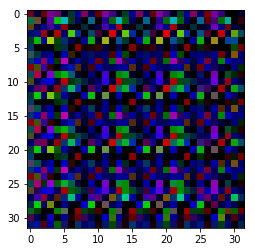

In [0]:
plt.imshow(im[0].T)

## With VAE:

In [0]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5)),
            nn.ELU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 64, (5, 5)),
            nn.ELU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(64, 256, (5, 5)),
            nn.ELU()
        )
        self.lin = nn.Linear(256, 200)  # Mean and log variance

    def forward(self, x):

        h = self.conv(x)
        h = self.lin(h.view(-1, 256))

        return h


class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()

        self.conv = nn.Sequential(
            nn.ELU(),

            nn.Conv2d(256, 64, (5, 5), padding=(3, 3)),  # 3
            nn.ELU(),
            nn.UpsamplingBilinear2d(scale_factor=2),  # 6

            nn.Conv2d(64, 32, (3, 3), padding=(2, 2)),  # 8
            nn.ELU(),
            nn.UpsamplingBilinear2d(scale_factor=2),  # 16

            nn.Conv2d(32, 16, (3, 3), padding=(1, 1)),  # 16
            nn.ELU(),
            nn.UpsamplingBilinear2d(scale_factor=2),  # 32
            nn.Conv2d(16, 3, (3, 3), padding=(1, 1))  # 32
        )

        self.conv1 = nn.Conv2d(256, 64, (5, 5), padding=(4, 4))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), padding=(2, 2))
        self.conv3 = nn.Conv2d(32, 16, (3, 3), padding=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, (3, 3), padding=(2, 2))
        self.lin = nn.Linear(100, 256)
        self.up1 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up2 = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x):

        h = self.lin(x)
        h = self.conv(h.view(-1, 256, 1, 1))

        return h


def sample_2(encoded_layer):
    mean, log_var = encoded_layer.chunk(2, 1)
    eps = torch.normal(mean=torch.zeros_like(mean), std=1).cuda()
    return mean + torch.exp(log_var/2)*eps


class VAE2(nn.Module):
    def __init__(self):
        super(VAE2, self).__init__()

        self.encoder = Encoder2()
        self.decoder = Decoder2()

    def forward(self, x):

        h = self.encoder(x)
        z = sample_2(h)
        return self.decoder(z), h

In [0]:
model = VAE2().cuda()

In [0]:
def ELBO_loss_fun(pred, truth, encoded_layer):
    mean, log_var = encoded_layer.chunk(2, 1)
    recon_loss = F.mse_loss(pred, truth, reduction='sum')
    kl = 0.5 * torch.sum(torch.exp(log_var) + mean.pow(2) - 1. - log_var)
    return recon_loss + kl

In [0]:
def evaluate(model, which=valid, verbose=0):
  loss = 0
  N = 0
  for data in which:
      data = torch.Tensor(data[0]).cuda()
      N += data.size()[0]
      output, encoded_layer = model(data)
      batch_loss = ELBO_loss_fun(output, data, encoded_layer)
      loss += batch_loss.cpu().detach().numpy()
      if verbose:
        print(loss)
  return -loss/N

In [0]:
evaluate(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


-515.7739303134811

In [0]:
num_epochs = 20
learning_rate = 3e-4

optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for data in train:
        
        data = Variable(data[0]).cuda()
        # ===================forward=====================
        output, encoded_layer = model(data)
        loss = ELBO_loss_fun(output, data, encoded_layer)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    # ===================loss========================
    val_loss = evaluate(model)
    print('epoch [{}/{}], batch loss:{:.4f}, val loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss) )

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch [1/20], batch loss:1081.9282, val loss:-114.0103
epoch [2/20], batch loss:1109.4548, val loss:-102.5434
epoch [3/20], batch loss:945.2983, val loss:-97.4262
epoch [4/20], batch loss:806.9844, val loss:-94.8250
epoch [5/20], batch loss:1057.8446, val loss:-92.9043
epoch [6/20], batch loss:909.4646, val loss:-92.0218
epoch [7/20], batch loss:601.4217, val loss:-91.1364
epoch [8/20], batch loss:817.3129, val loss:-89.7593
epoch [9/20], batch loss:772.3358, val loss:-89.6672
epoch [10/20], batch loss:1008.5624, val loss:-89.8052
epoch [11/20], batch loss:819.1549, val loss:-87.9199
epoch [12/20], batch loss:905.6630, val loss:-87.3742
epoch [13/20], batch loss:799.2285, val loss:-86.7940
epoch [14/20], batch loss:1062.4674, val loss:-86.5788
epoch [15/20], batch loss:1171.1210, val loss:-86.0669
epoch [16/20], batch loss:995.7873, val loss:-86.1376
epoch [17/20], batch loss:1003.1876, val loss:-85.9155
epoch [18/20], batch loss:929.1473, val loss:-85.6955
epoch [19/20], batch loss:77

Visual examples:

In [0]:
for data in train:
    original_pictures = data[0]
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


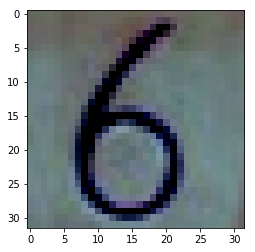

In [0]:
plt.imshow(np.swapaxes(original_pictures[9].numpy().T, 0, 1))
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


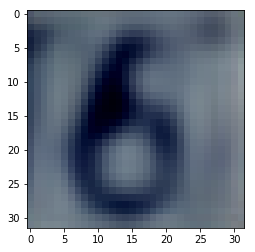

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


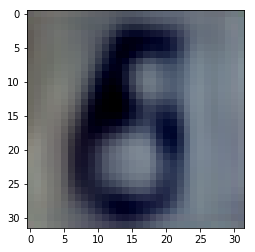

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


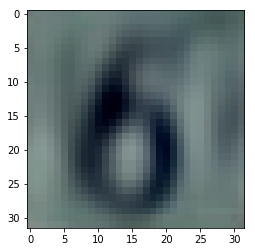

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


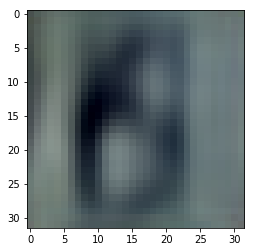

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


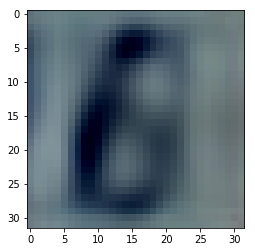

In [0]:
with torch.no_grad():
    _, encoded_layer = model(torch.Tensor(original_pictures[9]).view(1,3,32,32).cuda())
    
    for _ in range(5):
        z = sample_2(encoded_layer)
        generated_picture = model.decoder(z).cpu()
        plt.imshow(np.swapaxes(generated_picture[0].cpu().numpy().T, 0, 1))
        plt.show()

As we can see, the images generated are quite hazy and darker.

We believe this to be due to the fact that on each batch, about a third of the input pictures are completely black.

Disentanglement:

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


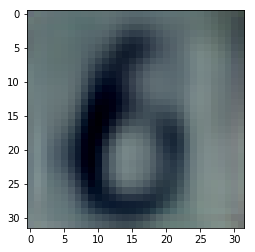

In [0]:
# For a given sample from the endoded layer:
with torch.no_grad():
    z = sample_2(encoded_layer)
    generated_picture = model.decoder(z).cpu()
    plt.imshow(np.swapaxes(generated_picture[0].cpu().numpy().T, 0, 1))
    plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


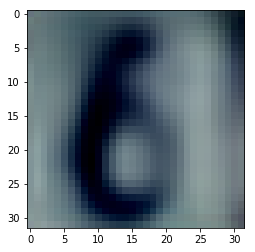

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


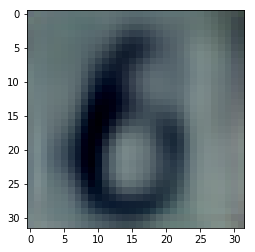

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


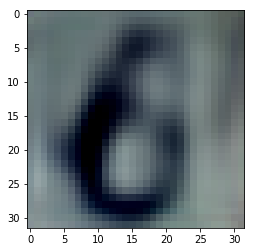

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


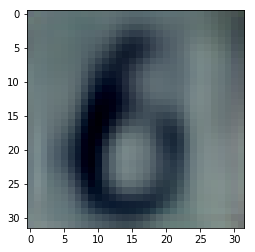

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


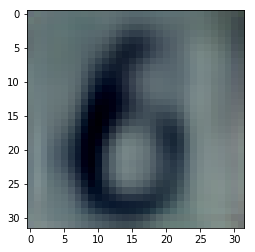

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


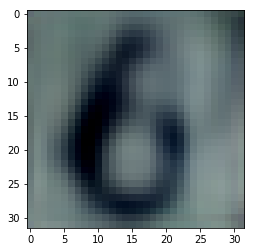

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


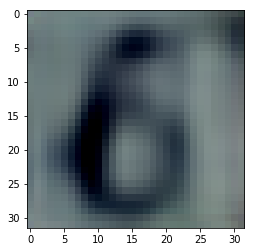

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


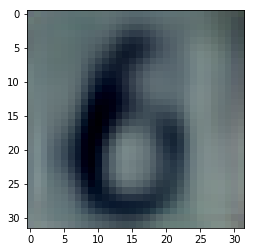

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


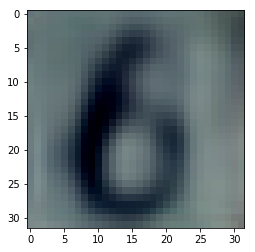

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


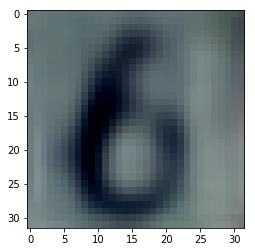

10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


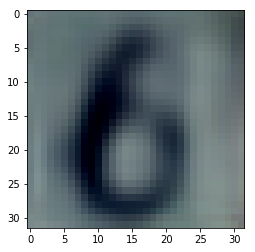

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11


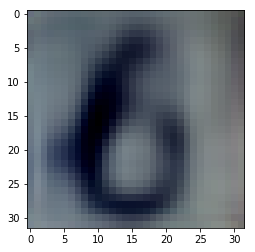

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12


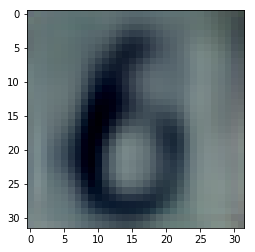

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13


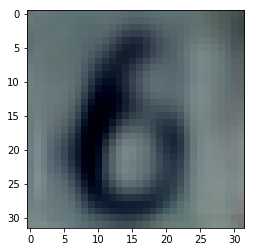

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14


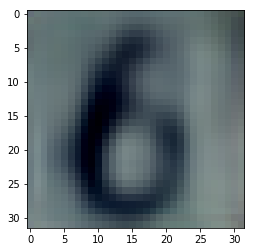

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


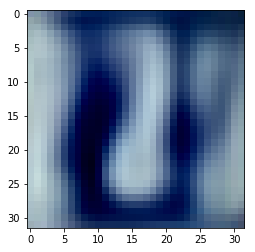

16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


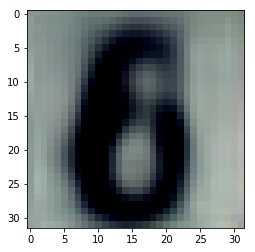

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17


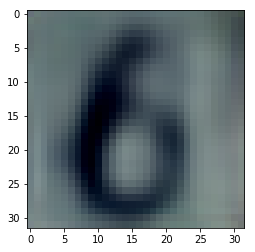

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


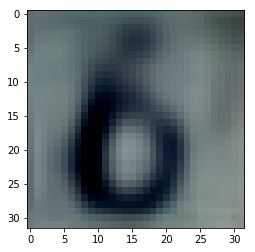

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19


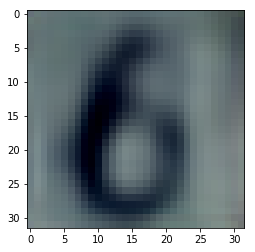

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


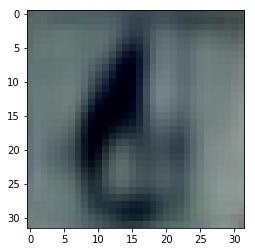

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


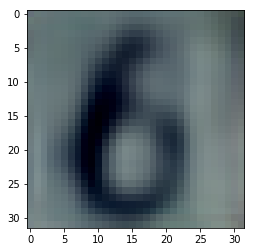

22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


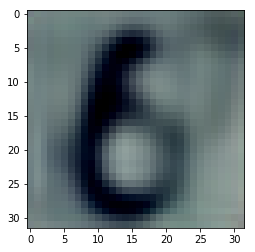

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23


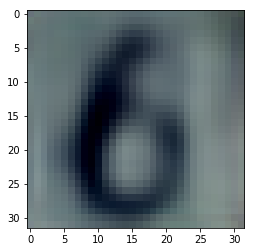

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24


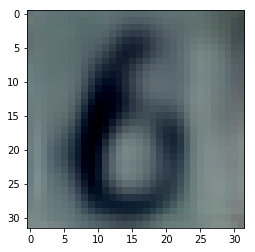

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25


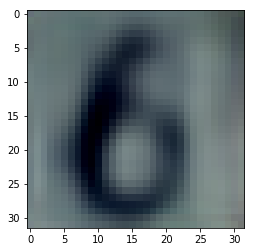

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26


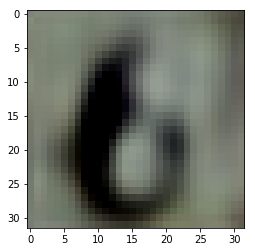

27


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


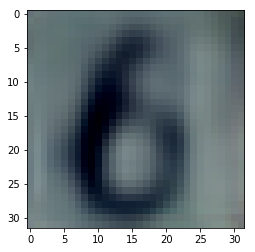

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28


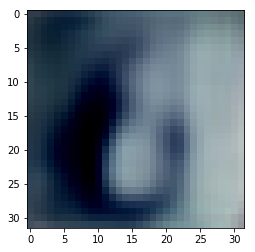

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29


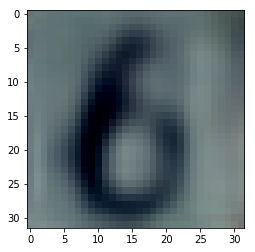

30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


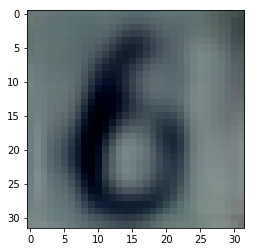

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31


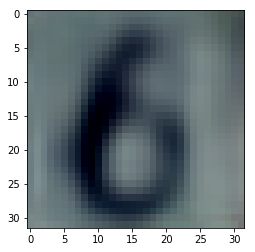

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32


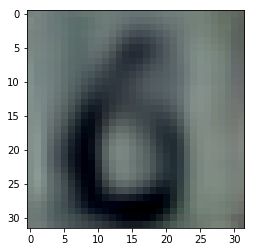

33


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


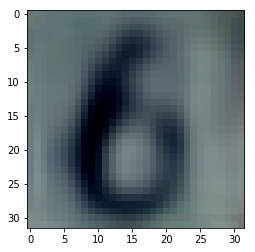

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34


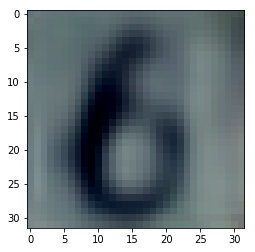

35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


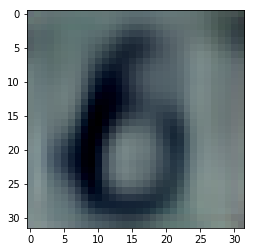

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36


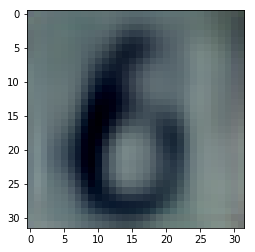

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37


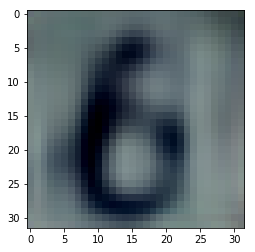

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38


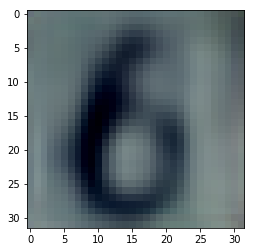

39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


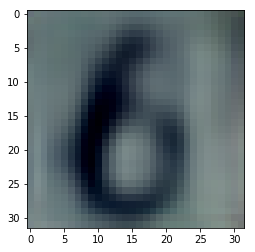

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40


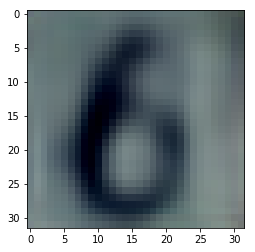

41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


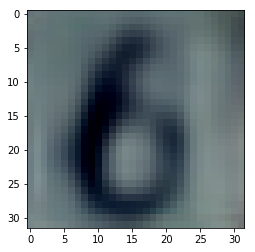

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42


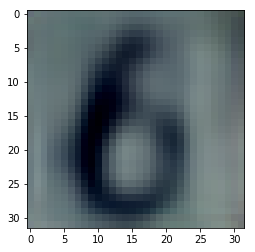

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43


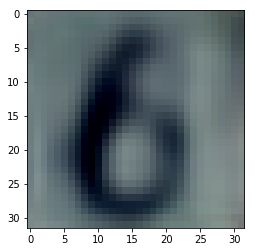

44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


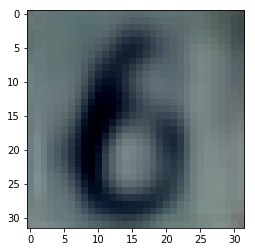

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45


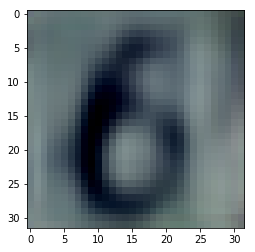

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46


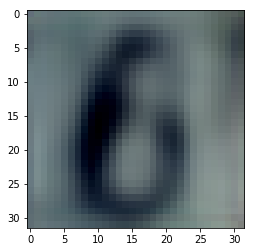

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47


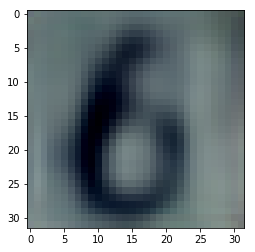

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48


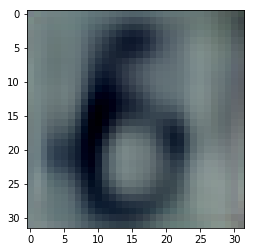

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49


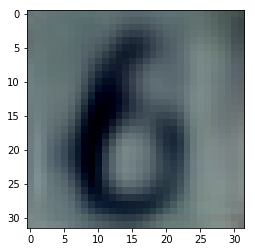

50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


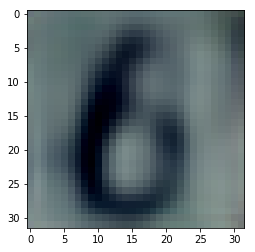

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


51


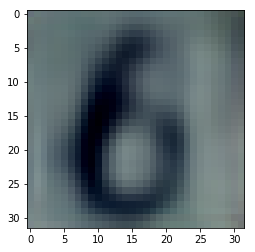

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


52


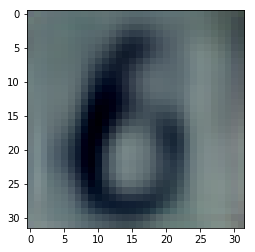

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


53


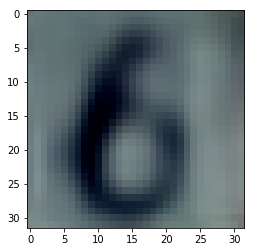

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


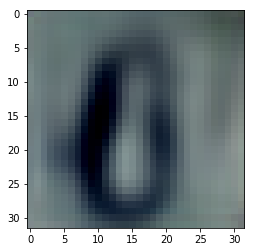

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


55


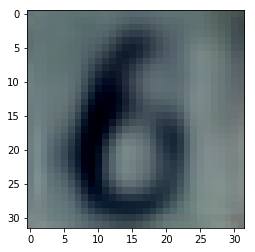

56


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


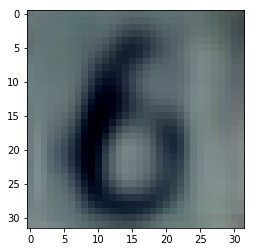

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


57


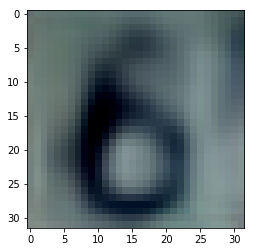

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


58


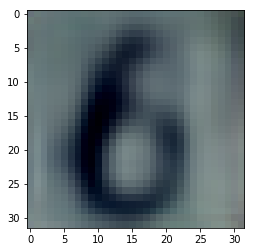

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


59


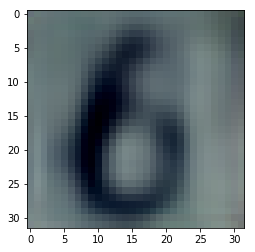

60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


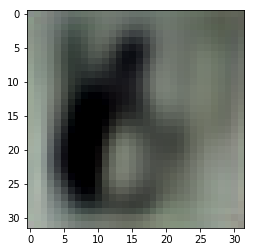

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


61


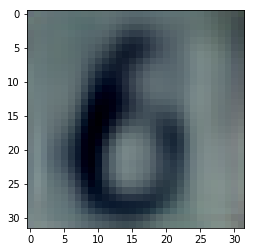

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62


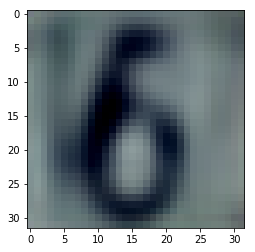

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


63


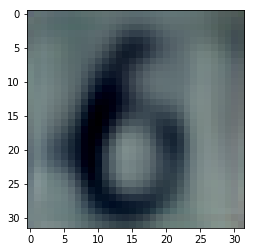

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


64


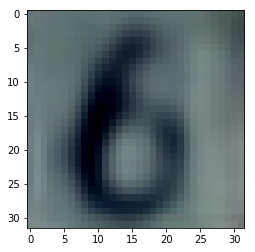

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65


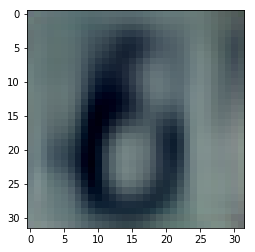

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


66


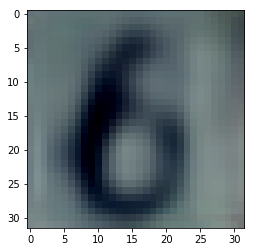

67


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


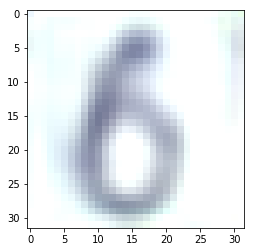

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


68


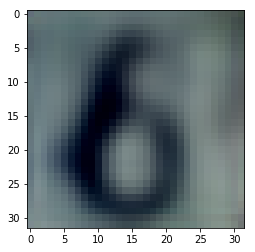

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


69


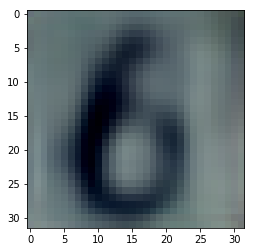

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70


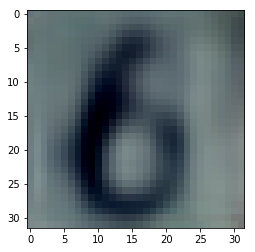

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


71


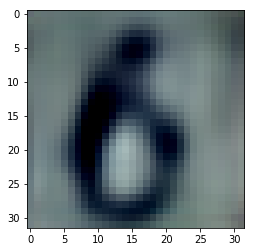

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


72


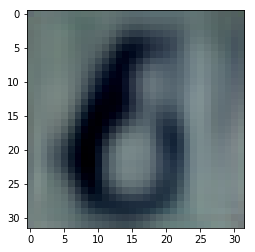

73


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


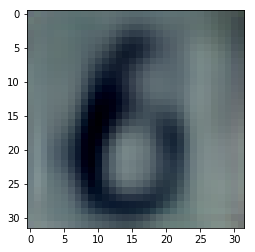

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74


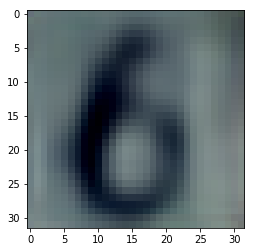

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


75


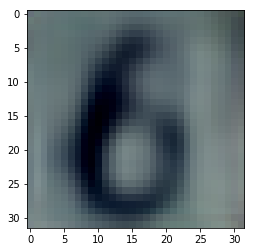

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


76


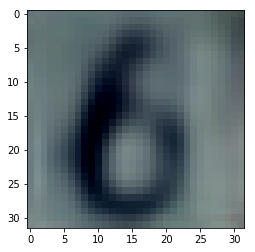

77


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


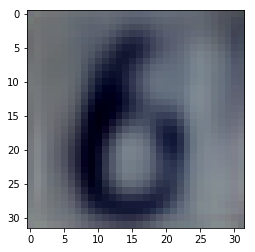

78


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


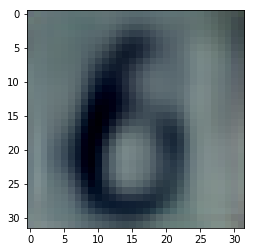

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


79


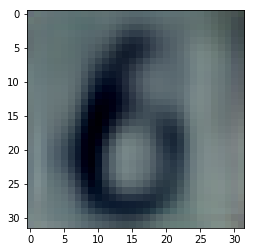

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


80


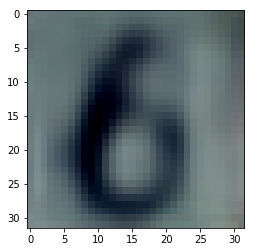

81


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


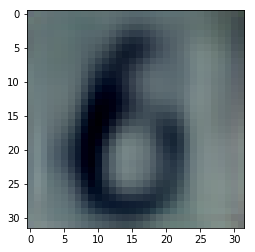

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


82


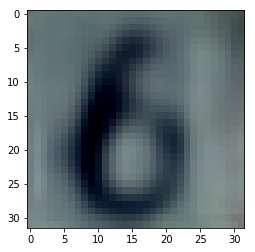

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


83


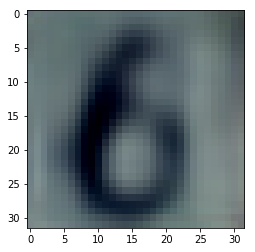

84


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


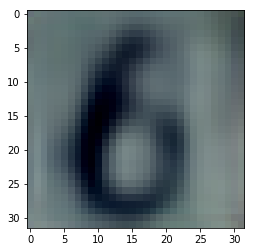

85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


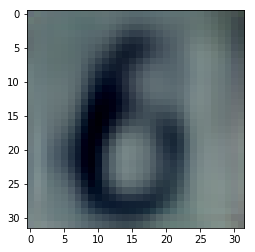

86


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


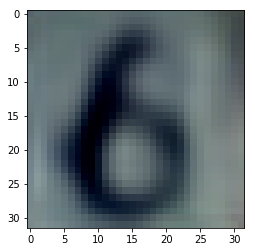

87

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


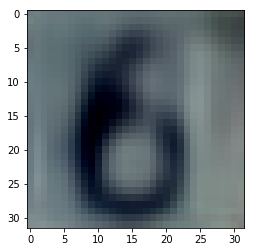

88


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


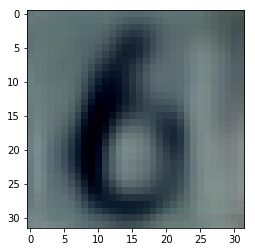

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


89


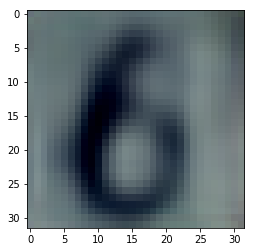

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90


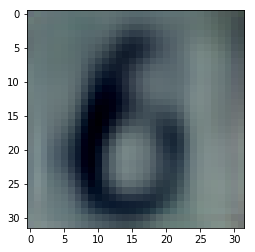

91


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


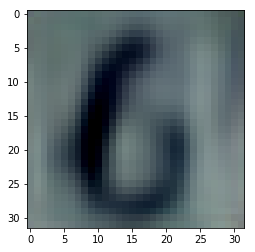

92


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


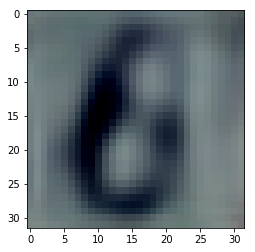

93


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


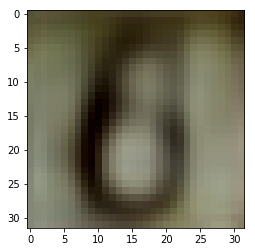

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


94


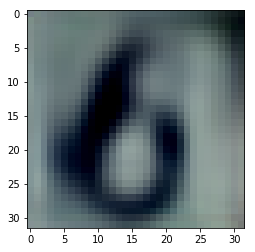

95


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


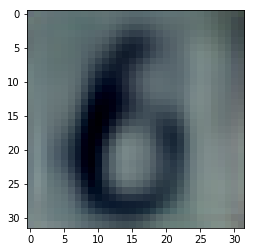

96


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


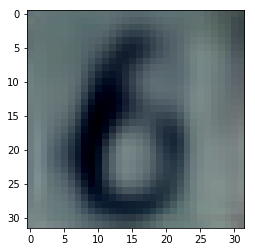

97


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


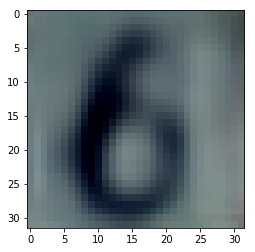

98


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


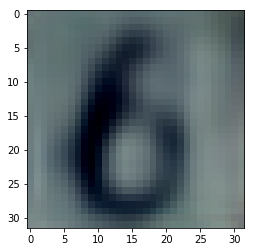

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


99


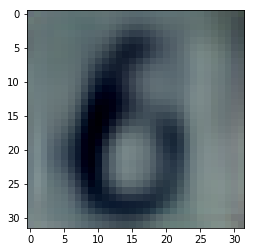

In [0]:
# For this given sample z, we'll make small modifications:
from copy import deepcopy
eps = 2
for i in range(z.size(1)):
    print(i)
    new_z = deepcopy(z.cpu().numpy())
    new_z[0][i]+=eps
    with torch.no_grad():
        gen_picture = model.decoder(torch.Tensor(new_z).cuda()).cpu()
    plt.imshow(np.swapaxes(gen_picture[0].cpu().numpy().T, 0, 1))
    plt.show()

As we can see, in most directions, there is little change to the image. In some directions however, there is a huge change. For instance, in direction 15.

Interpolation

In [0]:
def interpolate_latent(model, z1, z2):  # z as numpy samples
    a_list = []
    im_list = []
    for alpha in range(0, 11):
        a = alpha/10
        z = a*z1 + (1-a)*z2
        gen_picture = model.decoder(torch.Tensor(z).cuda()).cpu().numpy()
        a_list.append(a)
        im_list.append(np.swapaxes(gen_picture[0].T, 0, 1))
    return a_list, im_list

In [0]:
def interpolate_samples(model, z1, z2):  # z as numpy samples
    a_list = []
    im_list = []
    gen1 = model.decoder(torch.Tensor(z1).cuda())
    gen2 = model.decoder(torch.Tensor(z2).cuda())
    im1 = np.swapaxes(gen1[0].cpu().numpy().T, 0, 1)
    im2 = np.swapaxes(gen2[0].cpu().numpy().T, 0, 1)
    for alpha in range(0, 11):
        a = alpha/10
        a_list.append(a)
        im_list.append(a*im1 + (1-a)*im2)
    return a_list, im_list

In [0]:
def interpolate(model, pic1, pic2):
    with torch.no_grad():
        _, enc1 = model(torch.Tensor(pic1).view(1,3,32,32).cuda())
        _, enc2 = model(torch.Tensor(pic2).view(1,3,32,32).cuda())
        
        z1 = sample_2(enc1).cpu().numpy()
        z2 = sample_2(enc2).cpu().numpy()
        
        al_latent, iml_latent = interpolate_latent(model, z1, z2)
        al, iml = interpolate_samples(model, z1, z2)
            
        return al_latent, iml_latent, al, iml

Taking another image:

In [0]:
for data in train:
    pics2 = data[0]
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


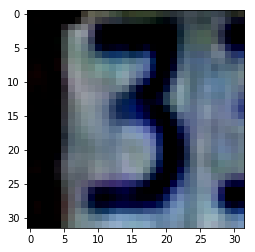

In [0]:
plt.imshow(np.swapaxes(pics2[1].numpy().T, 0, 1))
plt.show()

In [0]:
al_latent, iml_latent, al, iml = interpolate(model, original_pictures[9], pics2[1])

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


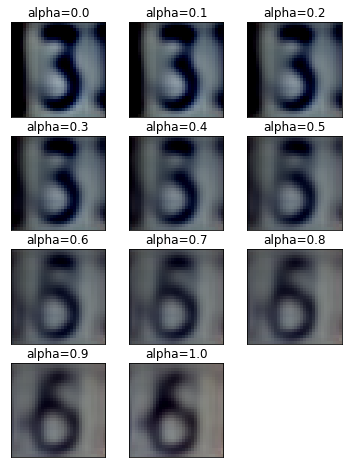

In [0]:
plt.figure(figsize=(6, 8))
for i, (a, im) in enumerate(zip(al_latent, iml_latent)):
    plt.subplot(4, 3, i+1)
    plt.title("alpha="+str(a))
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


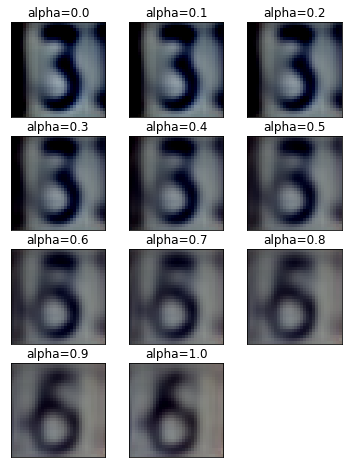

In [0]:
plt.figure(figsize=(6, 8))
for i, (a, im) in enumerate(zip(al, iml)):
    plt.subplot(4, 3, i+1)
    plt.title("alpha="+str(a))
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
plt.show()